In [6]:
# dependencies needed 
"""
pip install geos
pip install pyproj
pip install cartopy
pip install h5py
pip install netCDF4
pip install Cython
"""

"""
numpy
matplotlib
"""

'\nnumpy\nmatplotlib\n'

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  8 14:37:46 2020

@author: Amy.Huff

"""
#Import libraries and settings

#To perform array operations
import numpy as np 

#Main plotting libraries
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

#Libaries for drawing figures and map projections
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

#Library for reading netCDF files
from netCDF4 import Dataset

#Module for manipulating dates and times
import datetime

#Library for collecting lists of files from folders
import glob

import warnings
warnings.filterwarnings('ignore')

#Sets font size to 12
plt.rcParams.update({'font.size': 12})

#Option to keep numpy from printing in scientific notation by default
np.set_printoptions(suppress = True)

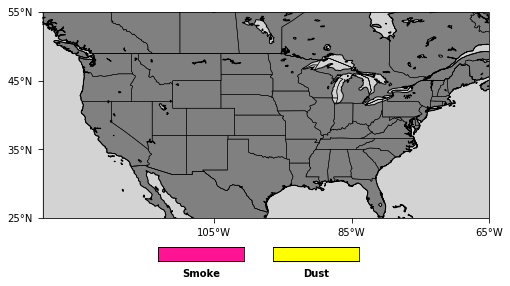

11-05-2020-abiadp/OR_G16_2020-11-05_00:03:05


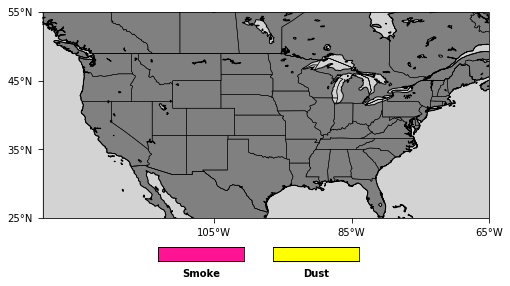

11-05-2020-abiadp/OR_G16_2020-11-05_00:13:05


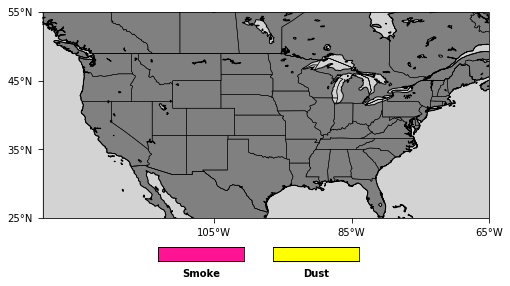

11-05-2020-abiadp/OR_G16_2020-11-05_00:23:05


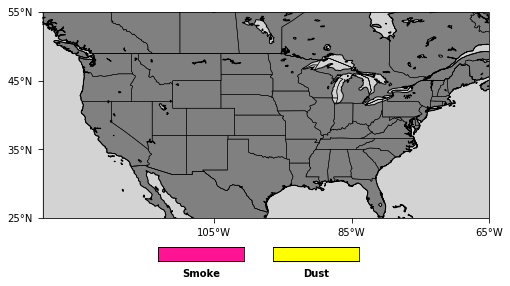

11-05-2020-abiadp/OR_G16_2020-11-05_00:33:05


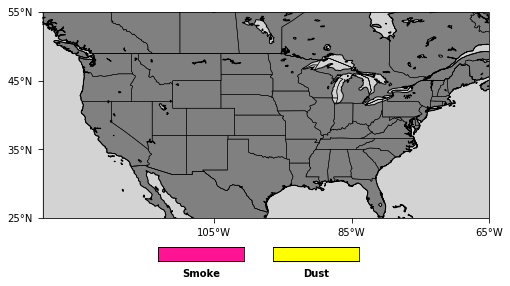

11-05-2020-abiadp/OR_G16_2020-11-05_00:43:05


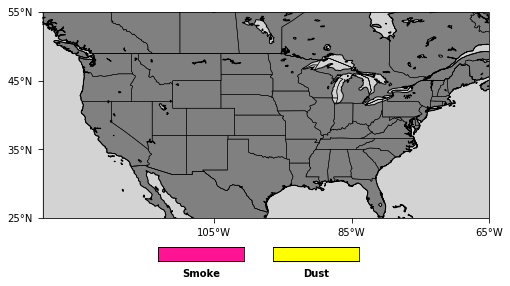

11-05-2020-abiadp/OR_G16_2020-11-05_00:53:05


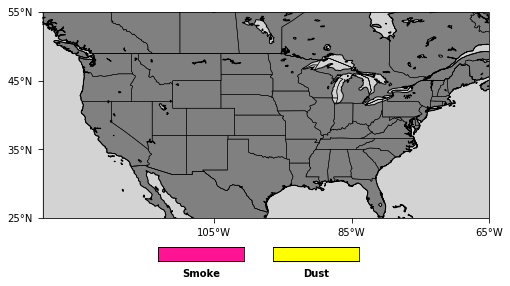

11-05-2020-abiadp/OR_G16_2020-11-05_01:03:05


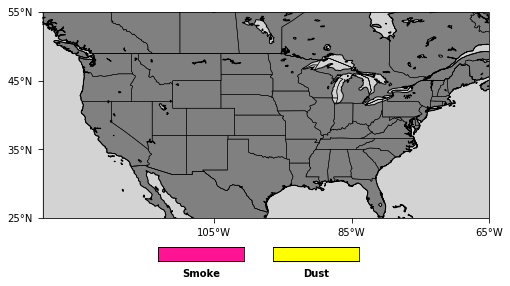

11-05-2020-abiadp/OR_G16_2020-11-05_01:13:05


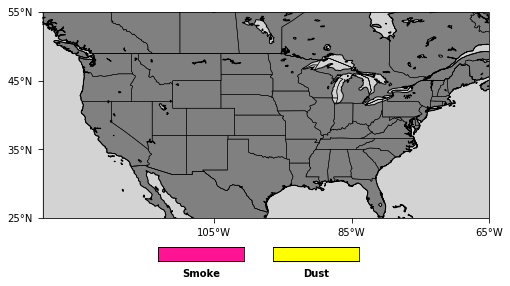

11-05-2020-abiadp/OR_G16_2020-11-05_01:23:05


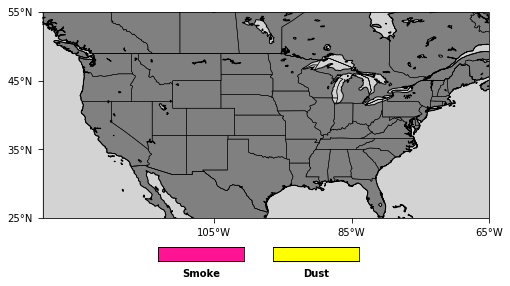

11-05-2020-abiadp/OR_G16_2020-11-05_01:33:05


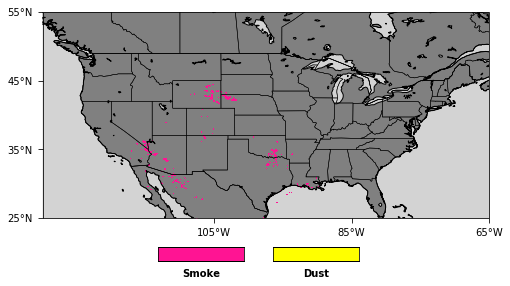

11-05-2020-abiadp/OR_G16_2020-11-05_21:23:05


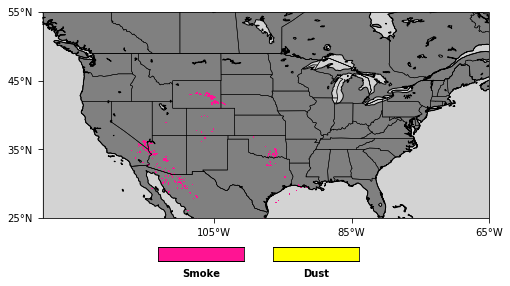

11-05-2020-abiadp/OR_G16_2020-11-05_21:33:05


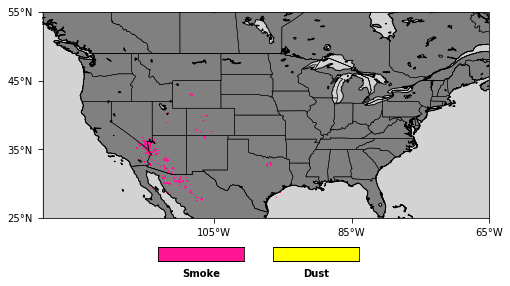

11-05-2020-abiadp/OR_G16_2020-11-05_21:43:05


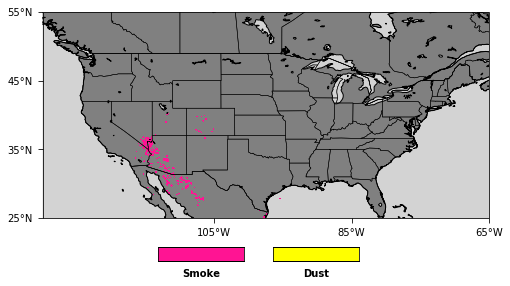

11-05-2020-abiadp/OR_G16_2020-11-05_21:53:05


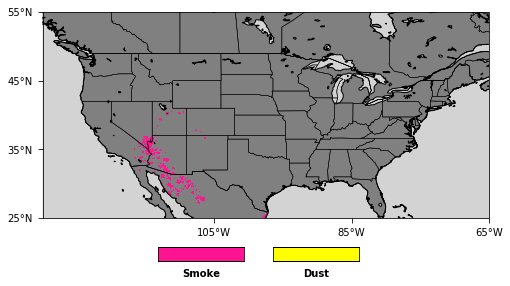

11-05-2020-abiadp/OR_G16_2020-11-05_22:03:05


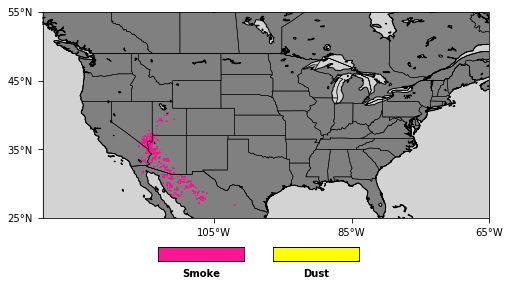

11-05-2020-abiadp/OR_G16_2020-11-05_22:13:05


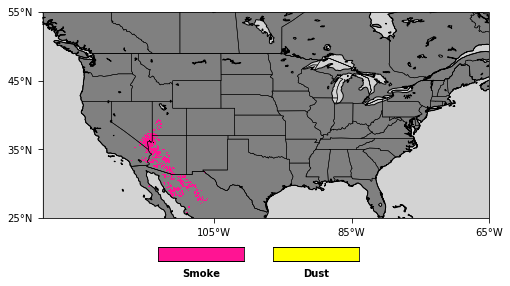

11-05-2020-abiadp/OR_G16_2020-11-05_22:23:05


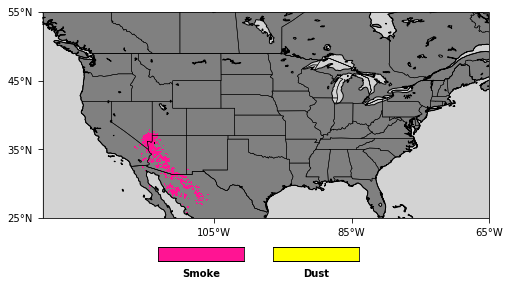

11-05-2020-abiadp/OR_G16_2020-11-05_22:33:05


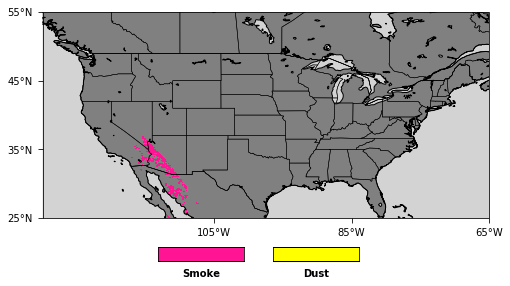

11-05-2020-abiadp/OR_G16_2020-11-05_22:43:05


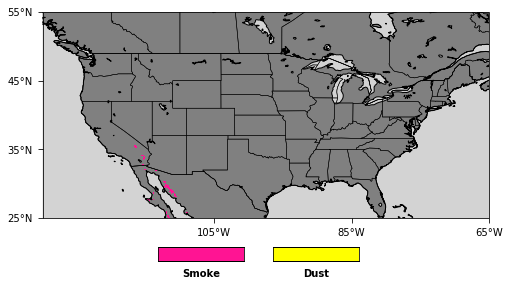

11-05-2020-abiadp/OR_G16_2020-11-05_22:53:05
Done!


In [10]:
#Algorithm to convert ABI latitude and longitude radian values to degrees
def degrees(file_id):
    proj_info = file_id.variables['goes_imager_projection']
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis
    
    #Data info
    lat_rad_1d = file_id.variables['x'][:]
    lon_rad_1d = file_id.variables['y'][:]
    
    #Create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)
    
    #lat/lon calculus routine from satellite radian angle vectors
    lambda_0 = (lon_origin*np.pi)/180.0
    
    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)
    
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    
    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)
    
    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return lat, lon


#Select and process ADP smoke/dust detection
def abi_adp(file_id):
    #Select all of the smoke pixels using the "Smoke" variable
    #smoke absent = 0, smoke present = 1
    smoke = file_id.variables['Smoke'][:,:]
    smoke_mask = (smoke == 0)
    smoke_present = np.ma.masked_where(smoke_mask, smoke)

    #Select all of the good quality smoke pixels using the "DQF" variable (bit 0)
    #good = 0, invalid = 1
    dqf = file_id.variables['DQF'][:,:]
    
    smoke_quality = (dqf & 0 == 1)
    smoke_good = np.ma.masked_where(smoke_quality, smoke_present)

    #Select all of the good quality smoke pixels within valid SZA/VZA using the "DQF" variable (bit 7)
    #within valid SZA/VZA for smoke and dust = 0, outside of valid SZA/VZA for smoke and dust = 128
    sza_mask = (dqf & 128 == 128)
    smoke_all = np.ma.masked_where(sza_mask, smoke_good)
    smoke_final = smoke_all.filled(0)

    #Select all of the dust pixels using "Dust" variable
    #dust absent = 0, dust present = 1
    dust = file_id.variables['Dust'][:,:]
    dust_mask = (dust == 0)
    dust_present = np.ma.masked_where(dust_mask, dust)

    #Select all of the good quality dust pixels using the "DQF" variable (bit 1)
    #good = 0, invalid = 2
    dust_quality = (dqf & 2 == 2)
    dust_good = np.ma.masked_where(dust_quality, dust_present)

    #Select all of the good quality dust pixels outside of sun-glint using the "DQF" variable (bit 6)
    #outside sun-glint = 0, within sun-glint = 64
    glint_mask = (dqf & 64 == 64)
    dust_glint = np.ma.masked_where(glint_mask, dust_good)

    #Select all of the good quality, outside sun-glint dust pixels within valid SZA/VZA using the "DQF" variable (bit 7)
    dust_all = np.ma.masked_where(sza_mask, dust_glint)
    dust_final = dust_all.filled(0)
    
    return smoke_final, dust_final


#Discrete color maps for ABI ADP smoke/dust detection
def adp_color_maps():
    smoke_color_map = mpl.colors.ListedColormap(['deeppink'])
    dust_color_map = mpl.colors.ListedColormap(['yellow'])
    
    return smoke_color_map, dust_color_map


#Create ABI ADP smoke/dust detection colorbars, independent of plotted data, auto-positioning
#cbar_ax are dummy variables
#Location/dimensions of colorbar set by .set_position (x0, y0, width, height) to scale automatically with plot
def adp_colorbars(fig, ax):
    last_axes = plt.gca()
    cbar1_ax = fig.add_axes([0, 0, 0, 0])
    cbar2_ax = fig.add_axes([0.1, 0.1, 0.1, 0.1])
    plt.draw()
    posn = ax.get_position()
    cbar1_ax.set_position([0.325, posn.y0 - 0.06, 0.15, 0.02])
    cbar2_ax.set_position([0.525, posn.y0 - 0.06, 0.15, 0.02])
    smoke_color_map, dust_color_map = adp_color_maps()
    norm = mpl.colors.Normalize(vmin = 0.5, vmax = 1.5)
    cb1 = mpl.colorbar.ColorbarBase(cbar1_ax, cmap = smoke_color_map, norm = norm, orientation = 'horizontal', ticks = [0.5, 1.5])
    cb1.set_label(label = 'Smoke', size = 10, weight = 'bold')
    cb1.ax.xaxis.set_major_formatter(ticker.NullFormatter())
    cb1.ax.tick_params(which = 'major', length = 0)
    cb2 = mpl.colorbar.ColorbarBase(cbar2_ax, cmap = dust_color_map, norm = norm, orientation = 'horizontal', ticks = [0.5, 1.5])
    cb2.set_label(label = 'Dust', size = 10, weight = 'bold')
    cb2.ax.xaxis.set_major_formatter(ticker.NullFormatter())
    cb2.ax.tick_params(which = 'major', length = 0)
    plt.sca(last_axes)
    
    
#Format map with lat/lon grid, coastlines/borders (Plate Carree projection)
def map_settings(ax):
    #Set up and label the lat/lon grid
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xticks(lon_ticks, crs = ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs = ccrs.PlateCarree())
    
    #Set lat/lon ticks and gridlines
    ax.tick_params(length = 5, direction = 'out', labelsize = 10, pad = 5)
    ax.grid(linewidth = 0.5, zorder = 3)
   
    #Draw coastlines/borders using Cartopy; zorder sets drawing order for layers
    ax.coastlines(resolution = '50m', zorder = 3)
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'ocean', scale = '50m'), facecolor = 'lightgrey')
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'land', scale = '50m'), facecolor = 'grey')
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'lakes', scale = '50m'), facecolor = 'lightgrey', edgecolor = 'black', zorder = 2)
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'cultural', name = 'admin_0_countries', scale = '50m'), facecolor = 'none', lw = 0.5, edgecolor = 'black', zorder = 3)
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'cultural', name = 'admin_1_states_provinces', scale = '50m'), facecolor = 'none', lw = 0.5, edgecolor = 'black', zorder = 3)
    
    #Set domain for map [x0, x1, y0, y1]
    ax.set_extent(domain, crs = ccrs.PlateCarree())


#Function to plot ABI ADP smoke/dust detection - Plate Carree projection
def plot_abi_adp(file_id, save=False):

    #Set up figure and map projection: PlateCarree(central_longitude)
    #Plate Carree: equidistant cylindrical projection w/equator as the standard parallel; default central_longitude = 0
    fig = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree())

    #Select and process smoke and dust ADP data
    smoke_final, dust_final = abi_adp(file_id)

    #Read in ABI latitutude and longitude values in degrees
    lat, lon = degrees(file_id)

    #Format map
    map_settings(ax)

    #Colormaps for plotting ADP data
    smoke_color_map, dust_color_map = adp_color_maps()

    #Add ADP colorbars
    adp_colorbars(fig, ax)
    
    #Create filled contour plots of smoke and dust data
    try:
        ax.contourf(lon, lat, smoke_final, levels = [0.5, 1.5, 3], cmap = smoke_color_map, zorder = 3, transform = ccrs.PlateCarree())
    except:
        pass
    try:
        ax.contourf(lon, lat, dust_final, levels = [0.5, 1.5, 3], cmap = dust_color_map, zorder = 3, transform = ccrs.PlateCarree()) 
    except:
        pass

    #Show figure
    plt.show()

    #Save figure as a .png file to specified subdirectory
    fname_attr = fname.split("_")
    date = datetime.datetime.strptime(fname_attr[4][1:-1], '%Y%j%H%M%S%f')
    filename = "_".join([fname_attr[0], fname_attr[2], date.strftime("%Y-%m-%d_%H:%M:%S")])
    
    if save:
#         date = datetime.datetime.strptime(fname[-49:-42], '%Y%j').date().strftime('%Y%m%d')
#         filename = 'G' + fname[-53:-51] + '_ABI_ADP_' + date + '_' + fname[-42:-38]
        fig.savefig(save_path + filename, bbox_inches = 'tight', dpi = file_res)
    print(filename)
    #Close file
    file_id.close()
    
    #Erase plot so we can build the next one
    plt.close()    

#####################################################################################   
#Plot ABI ADP data on Plate Carree projection

#Plot settings
file_res = 150  #dpi setting for image resolution
figures = 'multiple'  #number of figures to create: 'single' or 'multiple'

#File settings
file_path = '11-05-2020-abiadp/'  #location of data files
# file_name = 'OR_ABI-L2-ADPC-M6_G16_s20202581331152_e20202581333525_c20202581334526.nc' #for single file
# save_path = 'D://Data/2020/2020-09/20200914/Figures/'  #location for saved figures

#Mapping settings
#Use 180 degrees for longitude (i.e, 100 degrees W = -100)
domain = [-130, -65, 25, 55]
lon_ticks = [-105, -85, -65]
lat_ticks = [25, 35, 45, 55]


if figures == 'single':
    #Open single data file and set file name
    fname = file_path + file_name
    file_id = Dataset(fname)
    plot_abi_adp(file_id)
    print('Done!')

if figures == 'multiple':
    #Collect all of the .nc files in given subdirectory
    file_list = sorted(glob.glob(file_path + '*.nc')) 
    #Loop through data files, making/saving a figure for each data file
    for fname in file_list:
        file_id = Dataset(fname)
        plot_abi_adp(file_id)
    print('Done!')

In [45]:
file_path = "abi_adp/OR_ABI-L2-ADPC-M6_G16_s20202932141154_e20202932143527_c20202932144493.nc"
test = Dataset(file_path, "r", format="NETCDF4")
res_smoke_dust = abi_adp(test)  
res_degrees = degrees(test)
plot_abi_adp(test)